## System steup

In [1]:
from moleculekit.molecule import Molecule
import os
import importlib
from torchmdexp.metrics.rmsd import rmsd
from torchmdexp.metrics.l2_rmsd import l2_rmsd
from torchmdexp.metrics.log_rmsd import log_rmsd
from torchmdexp.metrics.tmscore import tm_score
from torchmdexp.samplers.utils import get_native_coords, get_embeddings
from moleculekit.projections.metricrmsd import MetricRmsd
from moleculekit.projections.metrictmscore import MetricTMscore
import numpy as np
import torch
from torchmdexp.metrics.native_contacts import q

device = "cuda:1"
precision = torch.float

In [ ]:
domain = '1ENH'
ref_pdb = f'/workspace7/torchmd-AD/crystals_dataset/crystals_short_64/level_1/ground_truth/{domain}.pdb'
ref_psf = f'/workspace7/torchmd-AD/crystals_dataset/topology_data/{domain}.psf'
#ref_xtc =  f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}_8kcenters.xtc'
#mol = Molecule(ref_xtc)
ref_mol = Molecule(ref_pdb)
ref_mol.filter('name CA')

mol = ref_mol
#mol.read(ref_psf)
ref_mol.read(ref_psf)

In [2]:
mol.resname
length = len(mol.resname)
length

NameError: name 'mol' is not defined

In [ ]:
#for i in range(length-1):
#    print(np.sqrt(np.square(mol.coords[i] - mol.coords[i+1]).sum()))

In [ ]:
#mol.read(ref_xtc)

In [3]:
#for i in range(32):
#mol = Molecule('/shared/carles/repo/torchmd-exp/data/ww/ww_ca_top_dih.psf')
#mol.read('/shared/carles/repo/torchmd-exp/data/ww/ww_kcenters_32clusters_coords.xtc')

ref_mol = Molecule('/shared/carles/repo/torchmd-exp/data/proteing/proteing_ca.pdb')
ref_mol.read('/shared/carles/repo/torchmd-exp/data/proteing/proteing_ca_top_dih.psf')

mol = ref_mol

In [4]:
# Compute starting coords
#[mol.dropFrames(1) for _ in range(32)]

#mol.coords = np.expand_dims(mol.coords[:, : , 0], axis=-1)
#mol.box = np.expand_dims(mol.box[:, 0], axis=-1)


native_coords = get_native_coords(ref_mol, device)
native_coords = native_coords.type(precision)
coords = get_native_coords(mol, device)
coords = coords.type(precision)


print('Starting rmsd: ', rmsd(coords, native_coords), 'Starting log_rmsd: ', log_rmsd(coords, native_coords))
print('Starting tmscore: ', tm_score(coords, native_coords), 'Starting l2_rmsd: ', l2_rmsd(coords, native_coords))


Starting rmsd:  tensor(0.0041, device='cuda:1') Starting log_rmsd:  tensor(0.0041, device='cuda:1')
Starting tmscore:  tensor(1.0000, device='cuda:1') Starting l2_rmsd:  tensor(0.4959, device='cuda:1')


In [5]:
from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters


ff = ForceField.create(mol, '/shared/carles/repo/torchmd-exp/data/ca_priors-dihedrals_general_5xweaker.yaml')
parameters = Parameters(ff, mol, precision=precision, device=device)

In [6]:
from torchmd.integrator import maxwell_boltzmann
from torchmd.systems import System

system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(parameters.masses, T=350, replicas=1))


In [7]:
# rotate the system positions
#import scipy.spatial.transform as trans

# rotate around x coord by 45 degrees and comput forces
#rot = trans.Rotation.from_euler("x", 45, degrees=True)
#system.pos[0] = torch.tensor(rot.apply(system.pos[0].cpu())).to(device)
#system.pos

In [8]:
if torch.any(torch.isnan(system.pos)):
    raise RuntimeError("Found NaN coordinates.")

In [9]:
get_embeddings(mol, 'cpu', 1)

tensor([[ 5, 13,  4, 19, 20, 14, 21, 14, 20,  9,  2, 13, 13,  3, 13,  4, 13, 13,
          6,  1, 14,  5,  1,  1, 13,  1,  6, 19, 14,  3, 19, 10,  4,  1,  9,  5,
          1,  2, 14,  5,  2,  6,  7, 13,  4,  5,  1,  1, 13, 19, 13,  3, 13, 14,
         13,  6]])

In [10]:
externalmodule = importlib.import_module('torchmdnet.calculators')
nnp = '/shared/carles/torchmd-exp/scripts/trainings/comparison/rmsd/fastfolders/2_layers_9_cutoff_400steps_half_native'
nnp += '/epoch=567-train_loss=1.4079-val_loss=2.1033.ckpt'
#nnp = '/workspace2/fast_folders_cgnet/multiprotein/M-test-fixed/NNP_torchMD2_moreHomeo/train_geom_multi_dih_4int_fix_homeo_rep2/'
#nnp += 'epoch=97-val_loss=719.2455-test_loss=21.2833.ckpt'
embeddings = torch.tensor([ 5, 13,  4, 19, 20, 14, 21, 14, 20,  9,  2, 13, 13,  3, 13,  4, 13, 13,
          6,  1, 14,  5,  1,  1, 13,  1,  6, 19, 14,  3, 19, 10,  4,  1,  9,  5,
          1,  2, 14,  5,  2,  6,  7, 13,  4,  5,  1,  1, 13, 19, 13,  3, 13, 14,
         13,  6]).repeat(1, 1)
external = externalmodule.External(nnp, embeddings, device)

In [11]:
print('Number of parameters nnp: ', sum(p.numel() for p in external.model.parameters() if p.requires_grad))

Number of parameters nnp:  157861


In [12]:
from torchmd.forces import Forces
#external=None
priors = ['bonds', 'repulsioncg', 'dihedrals']
forces = Forces(parameters,terms=priors, cutoff=9, rfa=False, switch_dist=None, 
                external=external, exclusions = ('bonds')
               )
# Evaluate current energy and forces. Forces are modified in-place
Epot = forces.compute(system.pos, system.box, system.forces, returnDetails=False)
print(Epot)
print(system.forces)

[-117.4950590133667]
tensor([[[ -3.1328, -13.4419,   7.5376],
         [  2.9126,  11.4096, -10.3574],
         [  0.5656, -12.5374,   8.7727],
         [-20.0238,   0.6680,   6.5999],
         [ 14.9175,  10.6114,  12.5983],
         [ -3.7111,  -1.0619,  -1.2087],
         [  6.9131, -13.5163,  -1.3119],
         [-11.4463,  10.9309,  -1.0855],
         [  5.0506,   4.2263,   0.2227],
         [ 12.2819,   2.3058,  10.3774],
         [ -8.9026,  -6.7038,  -9.8476],
         [  3.1775,  21.0495,  -4.9176],
         [ -9.7800, -10.5582,  11.5298],
         [  8.5523,  -2.1660,  -1.3671],
         [ -8.2933,  -0.0759,   5.0981],
         [  7.9156,  -3.3608,  -3.1249],
         [  0.3873,   9.2983, -16.6312],
         [  9.5957,  -4.4617,  -1.8838],
         [ -5.5112,  -9.2135,  -1.2936],
         [  2.4121,  10.5627,  -1.4036],
         [ -1.9968,  -6.2733,   5.1680],
         [  0.5988,  -9.0861,  -2.7627],
         [ -1.7518,  13.0218,  -0.0356],
         [  0.7803,   0.0670,   4.07

## Dynamics

In [13]:
from torchmd.integrator import Integrator
from torchmd.wrapper import Wrapper

langevin_temperature = 350  # K
langevin_gamma = 1
timestep = 5  # fs

integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)


In [14]:

def minimize_bfgs(system, forces, fmax=0.05, steps=1000):
    from scipy.optimize import minimize

    if steps == 0:
        print(
                "{0:4d}   {1: 3.6f}   {2: 3.6f}".format(
                    info["Nfeval"], Epot, np.max(np.linalg.norm(grad, axis=1))))
        return

    if system.pos.shape[0] != 1:
        raise RuntimeError(
            "System minimization currently doesn't support replicas. Talk with Stefan to implement it."
        )

    def evalfunc(coords, info):
        coords = coords.reshape(1, -1, 3)
        coords = torch.tensor(coords).type_as(system.pos)
        Epot = forces.compute(coords, system.box, system.forces)[0]
        grad = -system.forces.detach().cpu().numpy().astype(np.float64)[0]
        # display information
        #if info["Nfeval"] % 1 == 0:
            #print(
            #    "{0:4d}   {1: 3.6f}   {2: 3.6f}".format(
            #        info["Nfeval"], Epot, np.max(np.linalg.norm(grad, axis=1))
            #    )
            #)
        #info["Nfeval"] += 1
        return Epot, grad.reshape(-1)

    #print("{0:4s} {1:9s}       {2:9s}".format("Iter", " Epot", " fmax"))
    x0 = system.pos.detach().cpu().numpy()[0].astype(np.float64)

    res = minimize(
        evalfunc,
        x0,
        method="L-BFGS-B",
        jac=True,
        options={"gtol": fmax, "maxiter": steps, "disp": False},
        args=({"Nfeval": 0},),
    )

    system.pos = torch.tensor(
        res.x.reshape(1, -1, 3),
        dtype=system.pos.dtype,
        device=system.pos.device,
        requires_grad=system.pos.requires_grad,
    )

In [41]:
#from torchmd.minimizers import minimize_bfgs, minimize_pytorch_bfgs

print(rmsd(system.pos, native_coords))
print(minimize_bfgs(system, forces, steps=20000))  # Minimize the system
print(rmsd(system.pos, native_coords))

tensor(0.0041, device='cuda:1')
None
tensor(1.0023, device='cuda:1')


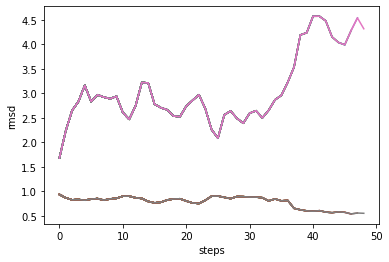

  5%|██                                       | 49/1000 [02:39<51:42,  3.26s/it]


KeyboardInterrupt: 

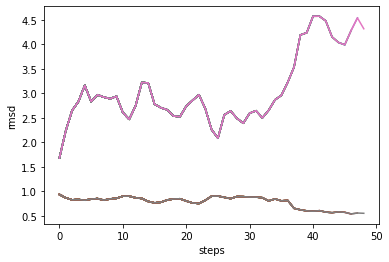

In [15]:
from tqdm import tqdm 
import numpy as np
%matplotlib inline
import time
import pylab as pl
from IPython import display
from torchmdexp.metrics.native_contacts import q

FS2NS = 1E-6 # Femtosecond to nanosecond conversion

steps = 100000
output_period = 100
save_period = 100
traj = []

trajectoryout = "mytrajectory.npy"

iterator = tqdm(range(1, int(steps / output_period) + 1))
Epot = forces.compute(system.pos, system.box, system.forces)
rmsds = []
Ep = []
Et = []
tm_scores = []
native_contacts = []

for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)
    
    rmsds.append(rmsd(system.pos, native_coords).item())
    tm_scores.append(tm_score(system.pos, native_coords).item())
    
    native_contacts.append(q(torch.squeeze(system.pos), native_coords).item())
    
    Ep.append(Epot)
    Et.append(Ekin + Epot)
    pl.plot(rmsds)
    pl.plot(native_contacts)
    pl.xlabel('steps')
    pl.ylabel('rmsd')
    
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [ ]:
#print(rmsds)

In [70]:
#print(tm_scores)

In [57]:
#pos_xtc = start_pos.detach().cpu().numpy().copy()
#mol.coords = np.moveaxis(pos_xtc, 0, -1)
#mol.write(f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}.pdb')

In [58]:
#mol.box = np.array([39.972, 39.941, 39.935], dtype=np.float32)

Text(0, 0.5, 'rmsd')

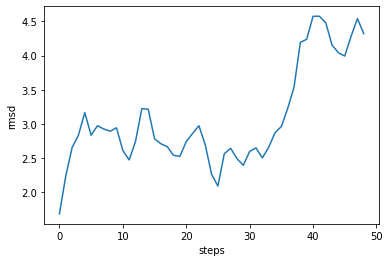

In [16]:
pl.plot(rmsds)
pl.xlabel('steps')
pl.ylabel('rmsd')

Text(0, 0.5, 'E')

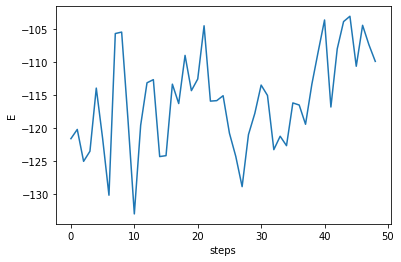

In [17]:
pl.plot(Ep)
pl.xlabel('steps')
pl.ylabel('E')

Text(0, 0.5, 'E')

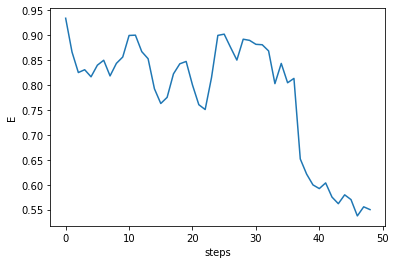

In [18]:
pl.plot(native_contacts)
pl.xlabel('steps')
pl.ylabel('E')

Text(0, 0.5, 'E')

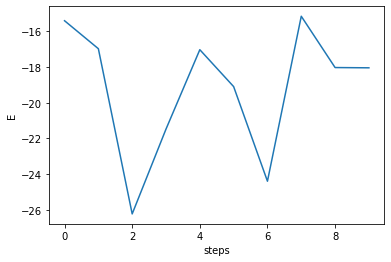

In [209]:
pl.plot(Et)
pl.xlabel('steps')
pl.ylabel('E')

In [67]:
max(1,2)

2

In [111]:
import torch

def get_3d_locations(d,h,w,device_):
      locations_x = torch.linspace(0, w-1, w).view(1, 1, 1, w).to(device_).expand(1, d, h, w)
      locations_y = torch.linspace(0, h-1, h).view(1, 1, h, 1).to(device_).expand(1, d, h, w)
      locations_z = torch.linspace(0, d-1,d).view(1, d, 1, 1).to(device_).expand(1, d, h, w)
      # stack locations
      locations_3d = torch.stack([locations_x, locations_y, locations_z], dim=4).view(-1, 3, 1)
      return locations_3d

def rotate(input_tensor, rotation_matrix):
      device_ = input_tensor.device
      _, d, h, w  = input_tensor.shape
      input_tensor = input_tensor.unsqueeze(0)
      print(input_tensor)
      # get x,y,z indices of target 3d data
      locations_3d = get_3d_locations(d, h, w, device_)
      # rotate target positions to the source coordinate
      rotated_3d_positions = torch.bmm(rotation_matrix.view(1, 3, 3).expand(d*h*w, 3, 3), locations_3d).view(1, d,h,w,3)
      rot_locs = torch.split(rotated_3d_positions, split_size_or_sections=1, dim=4)
      # change the range of x,y,z locations to [-1,1]
      normalised_locs_x = (2.0*rot_locs[0] - (w-1))/(w-1)
      normalised_locs_y = (2.0*rot_locs[1] - (h-1))/(h-1)
      normalised_locs_z = (2.0*rot_locs[2] - (d-1))/(d-1)
      grid = torch.stack([normalised_locs_x, normalised_locs_y, normalised_locs_z], dim=4).view(1, d, h, w, 3)
      # here we use the destination voxel-positions and sample the input 3d data trilinearly
      rotated_signal = F.grid_sample(input=input_tensor, grid=grid, mode='nearest',  align_corners=True)
      return rotated_signal.squeeze(0)


In [88]:
import torch
import torch.nn.functional as F

# Assume you have 2 values for each z,y,x location
data = torch.rand(2, 64, 256, 256).float()

# lets create a rotation  matrix
# for sanity check take identity as rotation matix firs
#rot_mat = torch.FloatTensor([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # identity
# then test with the following
rot_mat = torch.FloatTensor([[0, 1, 0],[1, 0, 0],[0, 0, 1]]) # 90 degreee rotation around z
print('rotation matrix \n', rot_mat)
print('determinant === ', torch.det(rot_mat))


rotation matrix 
 tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])
determinant ===  tensor(-1.)


In [56]:
rotated_data = rotate(data, rot_mat)
print(data.shape)
print(rotated_data.shape)
print(torch.mean(rotated_data - data)) # 0 , for identity rotation 

torch.Size([2, 64, 256, 256])
torch.Size([2, 64, 256, 256])
tensor(0.)


In [113]:
torch.rand(1, 3, 3, 3)

tensor([[[[0.1026, 0.9440, 0.6050],
          [0.2357, 0.4967, 0.7400],
          [0.4280, 0.2337, 0.6743]],

         [[0.1618, 0.5369, 0.3755],
          [0.9200, 0.8086, 0.2651],
          [0.1556, 0.8803, 0.1288]],

         [[0.3143, 0.9181, 0.1155],
          [0.0200, 0.5509, 0.1842],
          [0.1322, 0.3510, 0.2650]]]])

In [121]:
data = torch.rand(1, 3, 3, 1)
data

tensor([[[[0.0948],
          [0.9519],
          [0.3806]],

         [[0.3168],
          [0.1890],
          [0.9932]],

         [[0.5527],
          [0.7745],
          [0.2678]]]])

In [122]:
rotated_data = rotate(data, rot_mat)

tensor([[[[[0.0948],
           [0.9519],
           [0.3806]],

          [[0.3168],
           [0.1890],
           [0.9932]],

          [[0.5527],
           [0.7745],
           [0.2678]]]]])


In [123]:
rotated_data

tensor([[[[0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.]]]])

In [143]:
rot_mat = torch.FloatTensor([[0, 1, 0],[1, 0, 0],[0, 0, 1]]) # 90 degreee rotation around z

In [144]:
rot_mat @ torch.tensor([1.0,0.0,0.0])

tensor([0., 1., 0.])

In [133]:
system.forces.shape

torch.Size([1, 34, 3])

In [148]:
rot_mat @ forces[0][0]

tensor([ 0.1543, -0.7499, -0.8511])

tensor([-0.7499,  0.1543, -0.8511])

In [140]:
device

'cuda:1'

In [146]:
forces = system.forces.to('cpu')

In [150]:
import numpy as np

R_i = np.array(
    [
        -0.5630,
        0.5160,
        0.0071,
        0.5630,
        -0.5159,
        0.0071,
        -1.9293,
        -0.1506,
        -0.0071,
        1.9294,
        0.1505,
        -0.0071,
        -0.4724,
        1.1666,
        -0.8706,
        -0.4825,
        1.1551,
        0.8940,
        0.4825,
        -1.1551,
        0.8940,
        0.4723,
        -1.1665,
        -0.8706,
        -2.0542,
        -0.7710,
        -0.9003,
        -2.0651,
        -0.7856,
        0.8742,
        -2.7203,
        0.6060,
        -0.0058,
        2.0542,
        0.7709,
        -0.9003,
        2.7202,
        -0.6062,
        -0.0059,
        2.0652,
        0.7854,
        0.8743,
    ]
).reshape(-1, 3)
N = R_i.shape[0]
X_i = np.zeros((N, 2))
X_i[:4, 0] = 1
X_i[4:, 1] = 1

In [151]:
R_i

array([[-0.563 ,  0.516 ,  0.0071],
       [ 0.563 , -0.5159,  0.0071],
       [-1.9293, -0.1506, -0.0071],
       [ 1.9294,  0.1505, -0.0071],
       [-0.4724,  1.1666, -0.8706],
       [-0.4825,  1.1551,  0.894 ],
       [ 0.4825, -1.1551,  0.894 ],
       [ 0.4723, -1.1665, -0.8706],
       [-2.0542, -0.771 , -0.9003],
       [-2.0651, -0.7856,  0.8742],
       [-2.7203,  0.606 , -0.0058],
       [ 2.0542,  0.7709, -0.9003],
       [ 2.7202, -0.6062, -0.0059],
       [ 2.0652,  0.7854,  0.8743]])